# Blood donation prediction

In this Project, we work with data collected from the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes its blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. The dataset, obtained from the UCI Machine Learning Repository, consists of a random sample of 748 donors. 

Our goal is to predict if a blood donor will donate within a given time window.

## 1. Importing dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('transfusion.data')
data.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


Here, our dataset has 4 features and one target variable.

RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.

RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:

* R (Recency - months since the last donation)
* F (Frequency - total number of donation)
* M (Monetary - total blood donated in c.c.)
* T (Time - months since the first donation)
* a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)

## 2. Exploratory Data Analysis

Lets print more information about the data to look more closely to all the variables.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [4]:
data.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


It seems that, we do not have any missing values. All the variables are numeric types which is great for modelling. The Monetary feature has high variance. The dataset provider has done a good job at cleaning the data for us.

Now, we will compare our class labels for target variable to see their proportion out of total data points.

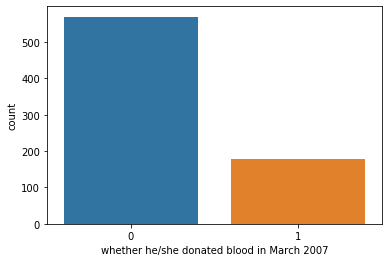

In [4]:
sns.countplot(data['whether he/she donated blood in March 2007'])

In [17]:
print('Percentage records labeled as 1:', round(data[data['whether he/she donated blood in March 2007']==1]['whether he/she donated blood in March 2007'].sum()/len(data),3))

Percentage records labeled as 1: 0.238


Around 24% of total records belongs to class '1'. If a model predicts all the labels as '0', that will still give us a 0.76 accuracy score. This is a benchmark for our machine learning model.

Next, it is important to see what sort of relationship is there between different features and how are they distributed. We can do that using a Pairplot.

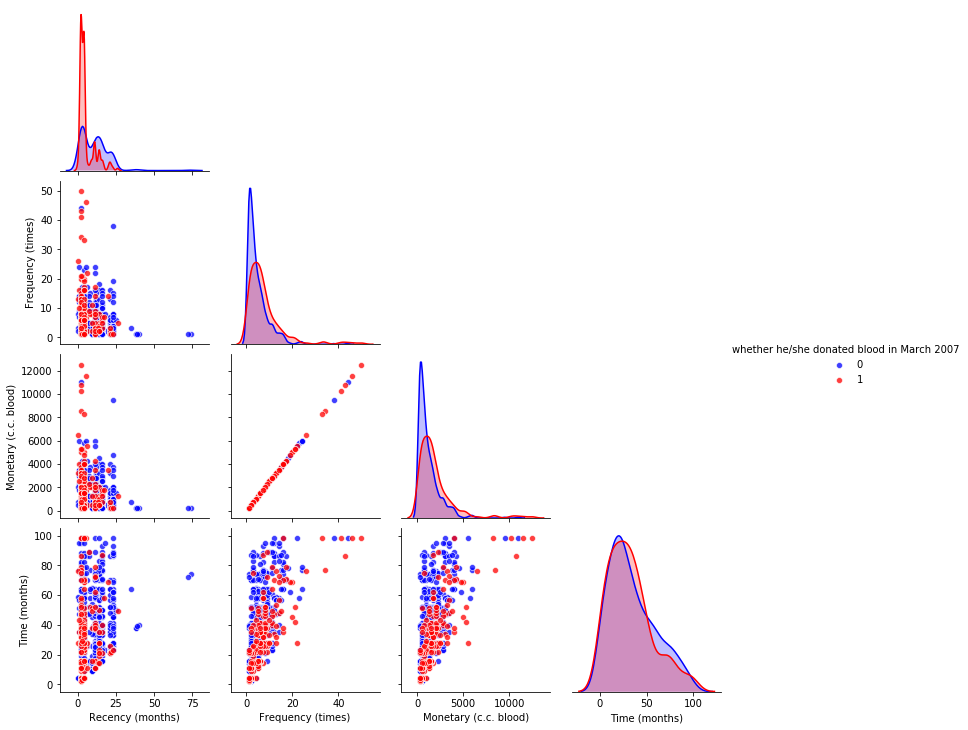

In [5]:
sns.pairplot(data, vars=['Recency (months)', 'Frequency (times)', 'Monetary (c.c. blood)', 'Time (months)'], 
             hue='whether he/she donated blood in March 2007',
             palette=['blue','red'],
             plot_kws=dict(alpha=0.75), 
             corner=True)

From the plot we can deduce following points:
* Distribution is right skewed.
* _Monetary_ feature has a linear relationship with _Frequency._
* Target labels can be loosely separated by a linear boundary.

We can see the correlation between these features by plotting a heatmap.

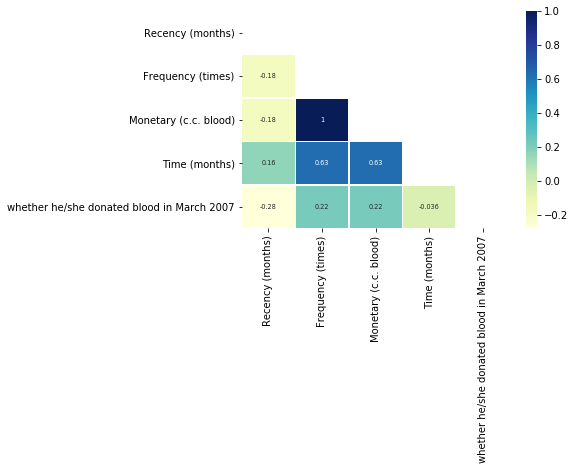

In [8]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(),cmap="YlGnBu",linewidths=0.5,annot=True,annot_kws={"size":6.5},mask=mask)

* As expected _Frequency_ is directly proportional to _Monetary_ as amount of blood collected from a donor is multiple of number of time the person donated the blood. Having both variables in our model is redundant as linearly dependent variable does not add any extra information. Hence, we can drop one of these feature.

In [13]:
data = data.drop('Monetary (c.c. blood)', axis=1)
print(data.shape)

y = data['whether he/she donated blood in March 2007']
X = data.drop('whether he/she donated blood in March 2007', axis=1)
print(y.shape)
print(X.shape)

(748, 4)
(748,)
(748, 3)



## 3. Building a baseline model

We will start with splitting our dataset into training and test set and will set _stratify_ parameter to _y_ to ensure the equivalent distribution of class labels between training and test sets.

Then, we can instantiate our first classifier, scikit learn's _Logistic Regression_ to fit our model.
* Here, _solver_ is an algorithm to use in the optimization problem. Default is ‘lbfgs’. For small datasets, ‘liblinear’ is a good choice, which supports 'l1' and 'l2' penalty.

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

logreg = LogisticRegression(solver='liblinear')
model = logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print(round(model.score(X_test, y_test),2))

0.79


In [4]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       171
           1       0.62      0.30      0.40        54

    accuracy                           0.79       225
   macro avg       0.71      0.62      0.64       225
weighted avg       0.76      0.79      0.76       225



The model achieved 79% accuracy. That is great compared to our benchmark of 76%. But, we will check if it can be improved by tuning hyperparameters. 

## 4. Hyperparameter tuning with RepeatedStratifiedKFold

Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This can be incorporated with sklearn's GridSearchCV method to find the best performing model.

* The _C_ parameter controls the penalty strength in logreg model.
* _n_splits_ in RepeatedStratifiedKFold is number of folds, default=5.
* _n_repeats_ is number of times cross validator needs to be repeated, default=10.

We will also bring all features to one scale using standardization before cross validation.

In [24]:
# define logreg parameters
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(penalty=penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=123)

scaler = StandardScaler()
scaledX_train = scaler.fit_transform(X_train)
print("std of scaled data:", np.std(scaledX_train))

grid_search = GridSearchCV(estimator=logreg, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(scaledX_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

std of scaled data: 1.0
Best: 0.773141 using {'C': 100, 'penalty': 'l1'}
0.773141 (0.029931) with: {'C': 100, 'penalty': 'l1'}
0.773141 (0.029931) with: {'C': 100, 'penalty': 'l2'}
0.773141 (0.029931) with: {'C': 10, 'penalty': 'l1'}
0.773141 (0.029931) with: {'C': 10, 'penalty': 'l2'}
0.773141 (0.028933) with: {'C': 1.0, 'penalty': 'l1'}
0.772502 (0.029119) with: {'C': 1.0, 'penalty': 'l2'}
0.769912 (0.023465) with: {'C': 0.1, 'penalty': 'l1'}
0.772481 (0.024423) with: {'C': 0.1, 'penalty': 'l2'}
0.762909 (0.005187) with: {'C': 0.01, 'penalty': 'l1'}
0.771182 (0.023832) with: {'C': 0.01, 'penalty': 'l2'}


Our accuracy has not improved through this process, rather it dropped by 2% for the best model found from the grid of different parameters. That shows we do not have much room for improvement when using Logistic Regression. 

## 5. K-Neighbors Classifier

To include the non linearity of our dataset in the model, we will train KNeighbors Classifier as it labels the points based on distance from surrounding points and does not draw one boundary line. However, it suffers from the curse of dimensionality but since our dataset is not too big, it should work well here. 

We will use a pipeline to scale and train the data and run a grid search for the best parameters.  

In [25]:
steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = {'knn__n_neighbors': np.arange(1,50),
             'knn__weights': ['uniform', 'distance'],
             'knn__metric' : ['minkowski','euclidean','manhattan']}
cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1)
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
print(cv.best_params_)

{'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}


In [26]:
print(cv.score(X_test, y_test))

0.8


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       171
           1       0.65      0.37      0.47        54

    accuracy                           0.80       225
   macro avg       0.73      0.65      0.67       225
weighted avg       0.78      0.80      0.78       225



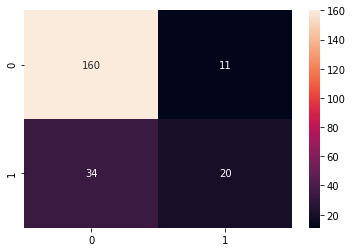

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

# 6. Conclusion

The best KNN model gives us 80% accuracy, 1% higher than Logistic Regression model and 4% better than simply choosing 0 all the time (the target incidence suggests that such a model would have 76% success rate). Future scope for this problem would be to increase the precision for minority class(labeled '1'). That means higher chances of correctly predicting a recurring blood donor.

The demand for blood fluctuates throughout the year. An accurate forecast for the future supply of blood allows for an appropriate action to be taken ahead of time and therefore saving more lives.